In [1]:
import tmol.score.ljlk.numba.lk_isotropic
display({"text/markdown" : tmol.score.ljlk.numba.lk_isotropic.__doc__}, raw=True)


# Baseline `fa_sol` implementation

(From Alford et al with revisions):

Rosetta utilizes an implicit solvation model combining both isotropic and
anisotropic components.

The isotropic (LK) desolvation component is an gaussian exclusion model
$f_{desolv}$, derived from [Lazaridis, Karplus'99]
(https://www.ncbi.nlm.nih.gov/pubmed/10223287), describing the energy
required to desolvate an atom $i$ when it is approached by a neighboring atom
$j$. In contrast to the original model, the $ΔG^{ref}$ term is removed in favor
of explict per-residue reference energies.

The energy of the atom-pair interaction varies with:

* Separation distance: $d_{i,j}$.
* Atomic radii: $σ_{i}$
* Experimentally determined vapor-to-water transfer free energy: $ΔG^{free}_i$
* Correlation length: $λ_i$
* Atomic volume of the desolvating atom, $V_j$

With a functional form:

$$
f_{desolv} =
    -V_i \frac{ΔG^{free}_i}{3\pi^{3/2} \lambda_i d_{i,j}^2}
    \exp \left[- \left(\frac{d_{i,j} - {\sigma}_{i}}{\lambda_i}\right)^2 \right]
$$

To accomodate softened repulsive potentials, which otherwise prevent
overlapping atomic radii, the potential is defined as a constant for $d_{i,j} <
{\sigma}_{i,j}$. To accomodate efficient truncated evaluation, the potential is
defined as 0 for $d_{i,j} >= 6Å$. Cubic polynomial interpolation $f_cpoly$ is
used to smoothly transition between these regions.

The final term is multiplied by a connectivity weight, $w_{i,j}^{conn}$, to
exclude the large repulsive energetic contributions that would otherwise be
calculated for atoms separated by fewer than four chemical bonds.  Such weights
are common to molecular force fields that assume that covalent bonds are not
formed or broken during a simulation. Rosetta uses four chemical bonds as the
“crossover” separation when $w_{i,j}^{conn}$ transitions from 0 to 1 (rather
than three chemical bonds as used by traditional force fields) to limit the
effects of double counting due to knowledge-based torsional potentials.

$$
w_{i,j}^{conn} = w_{j,i}^{conn} = \left\{
\begin{array}{ll}
  0.0 &
    \left| n_{i,j}^{bonds} \leq 3 \right. \\
  0.2 &
    \left| n_{i,j}^{bonds} = 4 \right. \\
  1.0 &
    \left| n_{i,j}^{bonds} \geq 4 \right. \\
\end{array}
\right.
$$

For a final piecewise definition:

$$
fa\_sol_{i,j}\left(d_{i,j} \right) =  w_{i,j}^{conn} \cdot \left\{
\begin{array}{ll}
  f_{desolv}({\sigma}_{i,j}) &
      d_{i,j} \in [ 0Å, {\sigma}_{i,j} - c_0 ) \\
  f_{cpoly\_low}(d_{i,j}) &
      d_{i,j} \in [ {\sigma}_{i,j} - c_0, {\sigma}_{i,j} + c_1 ) \\
  f_{desolv}(d_{i,j}) &
      d_{i,j} \in [ {\sigma}_{i,j} + c_1, 4.5Å ) \\
  f_{cpoly\_hi}(d_{i,j}) &
      d_{i,j} \in [ 4.5Å, 6.0Å ) \\
  0 &
      d_{i,j} \in [ 6.0Å, +\infty ) \\
\end{array}
\right|
\begin{array}{ll}
  c_0 = 0.3 Å \\
  c_1 = 0.2 Å \\
  f_{cpoly\_low}(\sigma_{i,j} - c_0) = f_{desolv}({\sigma}_{i,j}), \,
  f^\prime_{cpoly\_low}(\sigma_{i,j} - c_0) = 0 \\
  f_{cpoly\_low}(\sigma_{i,j} + c_1) = f_{desolv}(\sigma_{i,j} + c_1), \,
  f^\prime_{cpoly\_low}({\sigma}_{i,j} + c_1) = f_{desolv}^\prime(\sigma_{i,j} + c_1) \\
  f_{cpoly\_hi}(4.5Å) = f_{desolv}(4.5Å), \,
  f^\prime_{cpoly\_hi}(4.5Å) = f^\prime_{desolv}(4.5Å) \\
  f_{cpoly\_hi}(6.0Å) = 0, \,
  f^\prime_{cpoly\_hi}(6.0Å) = 0 \\
\end{array}
$$


In [2]:
import numpy
from matplotlib import pylab

from tmol.score.ljlk.numba.lk_isotropic import lk_isotropic_mutual, d_lk_isotropic_mutual_d_dist

import tmol.database

In [3]:
params = tmol.database.ParameterDatabase.get_default().scoring.ljlk

i = params.atom_type_parameters[0]
j = params.atom_type_parameters[2]

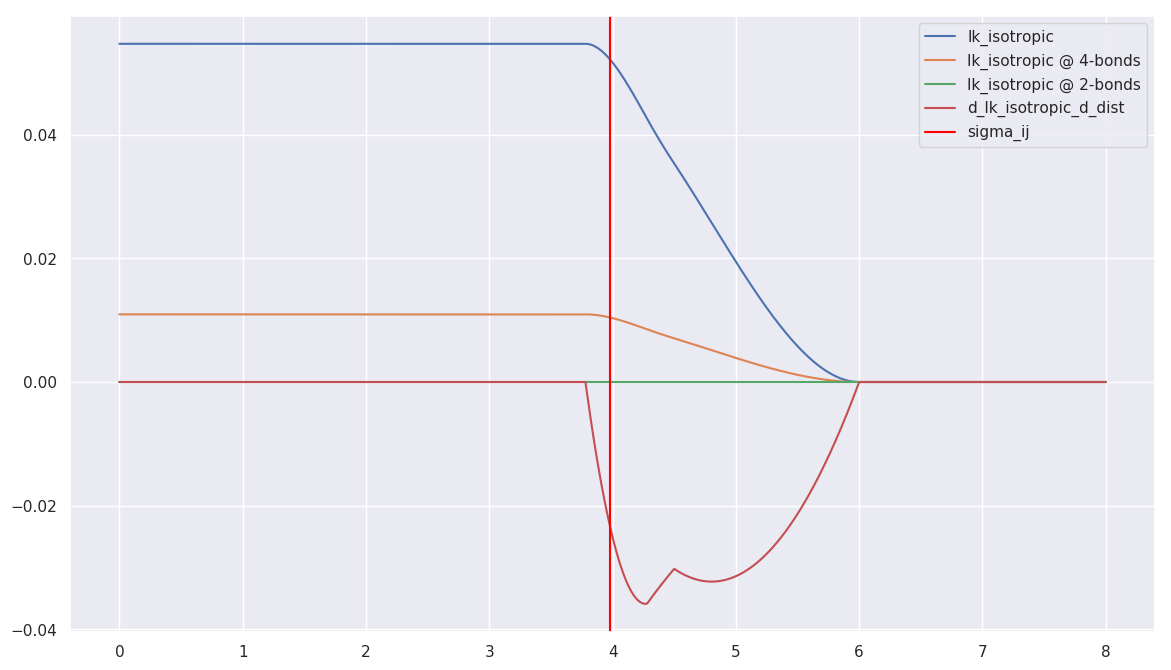

In [4]:
ds = numpy.linspace(0, 8, 1000)
pylab.plot(
    ds,
    lk_isotropic_mutual(
        ds,
        5,
        i.lj_radius,
        i.lk_dgfree,
        i.lk_lambda,
        i.lk_volume,
        j.lj_radius,
        j.lk_dgfree,
        j.lk_lambda,
        j.lk_volume,
    ),
    label="lk_isotropic",
)

pylab.plot(
    ds,
    lk_isotropic_mutual(
        ds,
        4,
        i.lj_radius,
        i.lk_dgfree,
        i.lk_lambda,
        i.lk_volume,
        j.lj_radius,
        j.lk_dgfree,
        j.lk_lambda,
        j.lk_volume,
    ),
    label="lk_isotropic @ 4-bonds",
)

pylab.plot(
    ds,
    lk_isotropic_mutual(
        ds,
        2,
        i.lj_radius,
        i.lk_dgfree,
        i.lk_lambda,
        i.lk_volume,
        j.lj_radius,
        j.lk_dgfree,
        j.lk_lambda,
        j.lk_volume,
    ),
    label="lk_isotropic @ 2-bonds",
)

pylab.plot(
    ds,
    d_lk_isotropic_mutual_d_dist(
        ds,
        5,
        i.lj_radius,
        i.lk_dgfree,
        i.lk_lambda,
        i.lk_volume,
        j.lj_radius,
        j.lk_dgfree,
        j.lk_lambda,
        j.lk_volume,
    ),
    label="d_lk_isotropic_d_dist",
)

pylab.axvline(i.lj_radius + j.lj_radius, color="red", label=r"sigma_ij")
pylab.legend(loc="best")